In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import pandas as pd
import numpy as np
import spell 

from nltk.sentiment import vader
from nltk.tokenize import TweetTokenizer
import nltk

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from Visualization import Visualization
#from random import shuffle
from sklearn.utils import shuffle

from imblearn.metrics import classification_report_imbalanced
from sklearn import metrics

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler


from sklearn import svm
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from matplotlib import cm as cmap

/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
data = pd.read_csv('rebtel_w_lexicon.csv')
data = data.dropna(subset=['Rel_title'], how='any')
data = data.reset_index()
del data['index']

In [4]:
data.head(n=2)

,Review,Title,Rating,day,month,year,hour,minute,second,dayofweek,...,Rel_wp_title,r_compound,r_negative,r_positive,r_neutral,t_compound,t_negative,t_positive,t_neutral,predictions
0,Rebtel I had been charged several times even w...,Charged without connetion,1,21,2,2017,9,27,7,2,...,Charged without connetion,-0.2023,-0.101,0.0,0.899,-0.2023,-0.474,0.0,0.526,2
1,I have topped up for 100$ mistakenly as in the...,Refund,1,16,2,2017,2,32,11,4,...,Refund,-0.5267,-0.124,0.0,0.876,0.0000,-0.000,0.0,1.000,2


## NORMALIZATION

In [5]:
v = vader.SentimentIntensityAnalyzer()
visual = Visualization()

In [6]:
def isrelevant(word):
    
    
    neu_relevant = {'big','app','skype','call','calls',
                    'scamming','billed',' messaging',
                    'website','cant','logo','max','go',
                    'get','cheap'}
    
    
    pol =  v.polarity_scores(word)
    
    if pol['neg'] == 1 or pol['pos'] == 1:
        return True
    else:
        if not word.isalpha():
            if word == "n't":
                return False
            else:
                return True
        else:
            if word.lower() in neu_relevant:
                return True
            else:
                
                return False
    

In [7]:
#tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

def spell_checked(data,columnName):
    
    avoid = {"``",",",'"',"`","-"}
    
    crtd_messages = []

    for m in data[columnName]:
        
        n_w = []
        for word in nltk.word_tokenize(m):
            if not isrelevant(word):
                tmp_w = spell.correct(word)
            else:
                tmp_w = word
            if tmp_w not in avoid:
                n_w.append(tmp_w)
        n_m = " ".join(n_w) 
        crtd_messages.append(n_m)
    
    return crtd_messages   

In [8]:
data['R_chk_title'] = spell_checked(data,'Rel_title')

In [11]:
data['R_chk_review'] = spell_checked(data,'Rel_review')

In [12]:
# Lemmatization
wordnet = WordNetLemmatizer() 

def lemmatization(data,columnName):
    lemmas = []
    for message in data[columnName]:
        tkn = nltk.word_tokenize(message)
        wordnet_lemmas = [wordnet.lemmatize(token) for token in tkn] 
        lemmas.append(" ".join(wordnet_lemmas))
    return lemmas

In [13]:
data["Lems_title"] = lemmatization(data,"R_chk_title")

In [14]:
data["Lems_review"] = lemmatization(data,"R_chk_review")

In [15]:
#Stemming
def stemming(data,columnName,stem): 
    lemmas = []
    
    snowball = SnowballStemmer("english")
    porter = PorterStemmer()
    lancaster = LancasterStemmer()
    
    for message in data[columnName]:
        tkn = nltk.word_tokenize(message)
        if stem is "snow":
            stemmed = [snowball.stem(token) for token in tkn]
        elif stem is "porter":
            stemmed = [porter.stem(token) for token in tkn]
        elif stem is "lanc":
            stemmed = [lancaster.stem(token) for token in tkn]
        lemmas.append(" ".join(stemmed))
    return lemmas

In [16]:
data["Snow_title"] = stemming(data,"R_chk_title","snow")  
data["Snow_review"] = stemming(data,"R_chk_review","snow")

In [17]:
data["Porter_title"] = stemming(data,"R_chk_title","porter") 
data["Porter_review"] = stemming(data,"R_chk_review","porter") 

In [18]:
data["Lanc_title"] = stemming(data,"R_chk_title","lanc") 
data["Lanc_review"] = stemming(data,"R_chk_review","lanc") 

In [ ]:
data.head(n=2)

In [19]:
# Join text from title and review
merged_text = []
for i in range(len(data)):
    mrgd = data["Lems_title"][i] + data["Lems_review"][i]
    merged_text.append(mrgd)

In [20]:
def mg_title_rev(data,approach):
    # Join text from title and review
    merged_text = []
    for i in range(len(data)):
        mrgd = data[approach + "_title"][i] + " " + data[approach + "_review"][i]
        merged_text.append(mrgd)
    return merged_text
    

In [21]:
data['Lems_title_review'] = mg_title_rev(data,"Lems")

In [22]:
data['Snow_title_review'] = mg_title_rev(data,"Snow")
data['Porter_title_review'] = mg_title_rev(data,"Porter")
data['Lanc_title_review'] = mg_title_rev(data,"Lanc")


In [23]:
#data['title_review'] = merged_text
data = data.reindex()

In [24]:
# Build a balanced train/test set
r1_df = data.loc[data.Rating == 1]
r2_df = data.loc[data.Rating == 2]
r3_df = data.loc[data.Rating == 3]
r4_df = data.loc[data.Rating == 4]
r5_df = data.loc[data.Rating == 5]
dfs = [r1_df, r2_df, r3_df, r4_df, r5_df]

In [25]:
t_size = 0.7

train_set = []
test_set = []

for df in dfs:
    
    train_size = int(len(df)* t_size)
    
    train_data = df[0:train_size].reset_index(drop=True)
    test_data = df[train_size:].reset_index(drop=True)
    
    train_set.append(train_data)
    test_set.append(test_data)

In [26]:
df_train = pd.concat(train_set[:],axis=0)
df_train = df_train.reset_index(drop=True)

df_test = pd.concat(test_set[:],axis=0)
df_test = df_test.reset_index(drop=True)


In [252]:
df = pd.concat([df_train,df_test],axis=0)
df = shuffle(df).reset_index(drop=True)

In [ ]:
"""
#Select method to train model (Lems/Snow/Porter/Lanc)
method =  "Lems" 
x_train, y_train = df_train[method + '_title_review'].values, df_train['Rating'].values
x_test, y_test = df_test[method + '_title_review'].values, df_test['Rating'].values

x_train, y_train = x_train.reshape(x_train.shape[0],), y_train.reshape(y_train.shape[0],)
x_test, y_test = x_test.reshape(x_test.shape[0],), y_test.reshape(y_test.shape[0],)

"""

In [ ]:
"""
# Extract text from title/reviews to build bag of words
x_ti_data = data["Lems_title"].values
x_ti_data = x_ti_data.reshape(x_ti_data.shape[0],)

x_re_data = data["Lems_review"].values
x_re_data = x_re_data.reshape(x_re_data.shape[0],)

x_data = data['title_review'].values
x_data = x_data.reshape(x_data.shape[0],)
"""

In [255]:
# Extract true labels from data
y_data = df["Rating"].values
y_data = y_data.reshape(y_data.shape[0],)

In [ ]:
"""
# 
print("Classes: ")
print(np.unique(y_train))

# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(x_train))))

# Summarize review length
print("Review length: ")
result = [len(x) for x in x_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.title('Lenght of words in message reviews')
plt.show()

# Summarize review length
print("Review length: ")
result = [len(x) for x in x_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.title('Lenght of words in title reviews')
plt.show()
"""

In [ ]:
#Check distribution of classes
#df.Rating.value_counts().plot(kind='bar')

In [531]:
# Set up Vectorizer with the X most frequent words
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None,   \
                             max_features = 125)
RANDOM_STATE = 0
seed = 18
np.random.seed(seed)

In [532]:
ctyNames = df.Country.unique() 
ctyNames = np.append(ctyNames,['Unkown'])
countries = {ctyNames[i]: i for i in range(0, len(ctyNames))}

In [533]:
def map_country(ctyName,countries):
    
    if ctyName in countries:
        value = countries[ctyName]
    else:
        value = countries['Unkown']

    return value

In [534]:
df['Key_country'] = [map_country(cty,countries) for cty in df.Country]

In [499]:
#ADD MORE FEATURES


add_feats = df[['Reads','Useful','Reviews','Key_country']]
a_feats = add_feats.values

In [548]:
#Select method to train model (Lems/Snow/Porter/Lanc)
method =  "Lanc"
add_feats = True

x_fts = vectorizer.fit_transform(df[method + '_title_review'])
x_fts = x_fts.toarray()


if add_feats:
    x_fts = np.concatenate((x_fts,a_feats),axis=1)



train_size = 0.7
train_size = int(len(x_fts)* train_size)

x_train, y_train = x_fts[0:train_size], df['Rating'][0:train_size]
x_test, y_test = x_fts[train_size:], df['Rating'][train_size:] 



In [524]:
"""
ros = RandomOverSampler(random_state=RANDOM_STATE)
x_train, y_train = ros.fit_sample(x_train, y_train)
x_test, y_test = ros.fit_sample(x_test, y_test)

x_data  = np.concatenate((x_train,x_test),axis=0)
y_data = np.concatenate((y_train,y_test),axis=0)
"""

In [550]:
x_train.shape

(1267, 129)

In [556]:
#cross_validation = StratifiedShuffleSplit(y_data, n_iter=15, test_size=0.3, random_state=RANDOM_STATE)
cross_validation =   StratifiedKFold (y_train,n_folds=10, random_state=RANDOM_STATE)

scores = []
confusion_matrices = []
clf_models = []
avgs = []

for train_index,test_index in cross_validation:

    clf = None

    dx_train, dy_train = x_train[train_index], y_train[train_index]
    dx_test, dy_test = x_train[test_index], y_train[test_index]
    
    clf = RandomForestClassifier(n_estimators= 77, n_jobs=-1,random_state=RANDOM_STATE)
    #clf = svm.SVC(decision_function_shape='ovo',random_state=RANDOM_STATE,probability=True)
    clf.fit(dx_train, dy_train)
    clf_models.append(clf)
    
    # Saving the scores.
    test_score = clf.score(dx_test, dy_test)
    test_preds = clf.predict(dx_test)
    rep = classification_report_imbalanced(dy_test, test_preds)
    txt_rep = nltk.word_tokenize(rep[500:1000])
    avg_total = [float(txt_rep[i]) for i in range(3,len(txt_rep))]
    avgs.append(avg_total)
    scores.append(test_score)


    # Saving the confusion matrices.
    data_classes_pred = clf.predict(dx_test) 
    cm = confusion_matrix(dy_test, test_preds)
    confusion_matrices.append(cm)
    
print('Average precision :', str(np.mean([avgs[i][0] for i in range(len(avgs))])))
print('Average recall :', str(np.mean([avgs[i][1] for i in range(len(avgs))])))
print('Average F-score :', str(np.mean([avgs[i][3] for i in range(len(avgs))])))

/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/imblearn/metrics/classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)
/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/imblearn/metrics/classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_f

Average precision : 0.526
Average recall : 0.578
Average F-score : 0.532


In [552]:
clf = RandomForestClassifier(n_estimators= 37, n_jobs=-1,random_state=RANDOM_STATE)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=37, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [554]:
test_preds = clf.predict(x_test)
print(classification_report_imbalanced(y_test, test_preds))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.59      0.65      0.93      0.62      0.75      0.54        72
          2       0.25      0.03      0.99      0.06      0.49      0.22        31
          3       0.33      0.17      0.96      0.23      0.55      0.28        58
          4       0.42      0.32      0.87      0.36      0.58      0.32       124
          5       0.64      0.83      0.58      0.72      0.71      0.50       258

avg / total       0.53      0.57      0.76      0.54      0.66      0.43       543



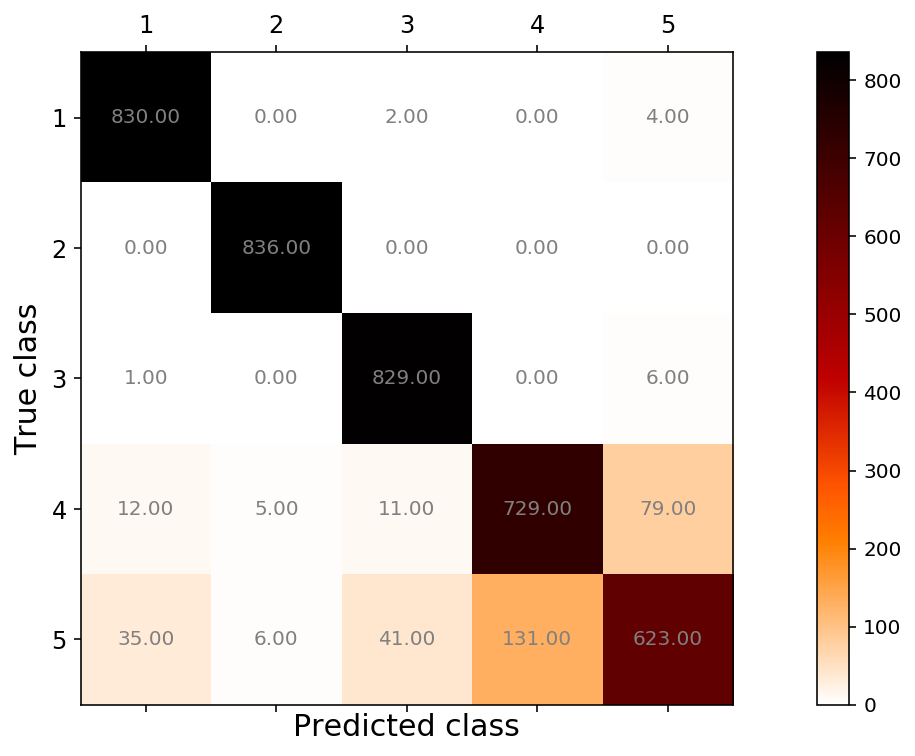

In [528]:
tip_labels = ['1' , '1', '2', '3', '4', '5']


first = True
cm = None

for cm_iter in confusion_matrices:
    if first:
        cm = cm_iter.copy()
        first = False
    else:
        
        cm = cm + cm_iter

fig, axes = plt.subplots(figsize=(15,6))
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
colorbar = axes.matshow(cm, cmap=cmap.gist_heat_r)
fig.colorbar(colorbar)

for (i, j), z in np.ndenumerate(cm):
            axes.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',color='gray')


axes.set_xlabel('Predicted class', fontsize=15)
axes.set_ylabel('True class', fontsize=15)

axes.set_xticklabels(tip_labels)
axes.set_yticklabels(tip_labels)

axes.tick_params(labelsize=12)

In [434]:
#visual.counter(y_train,'y_train')

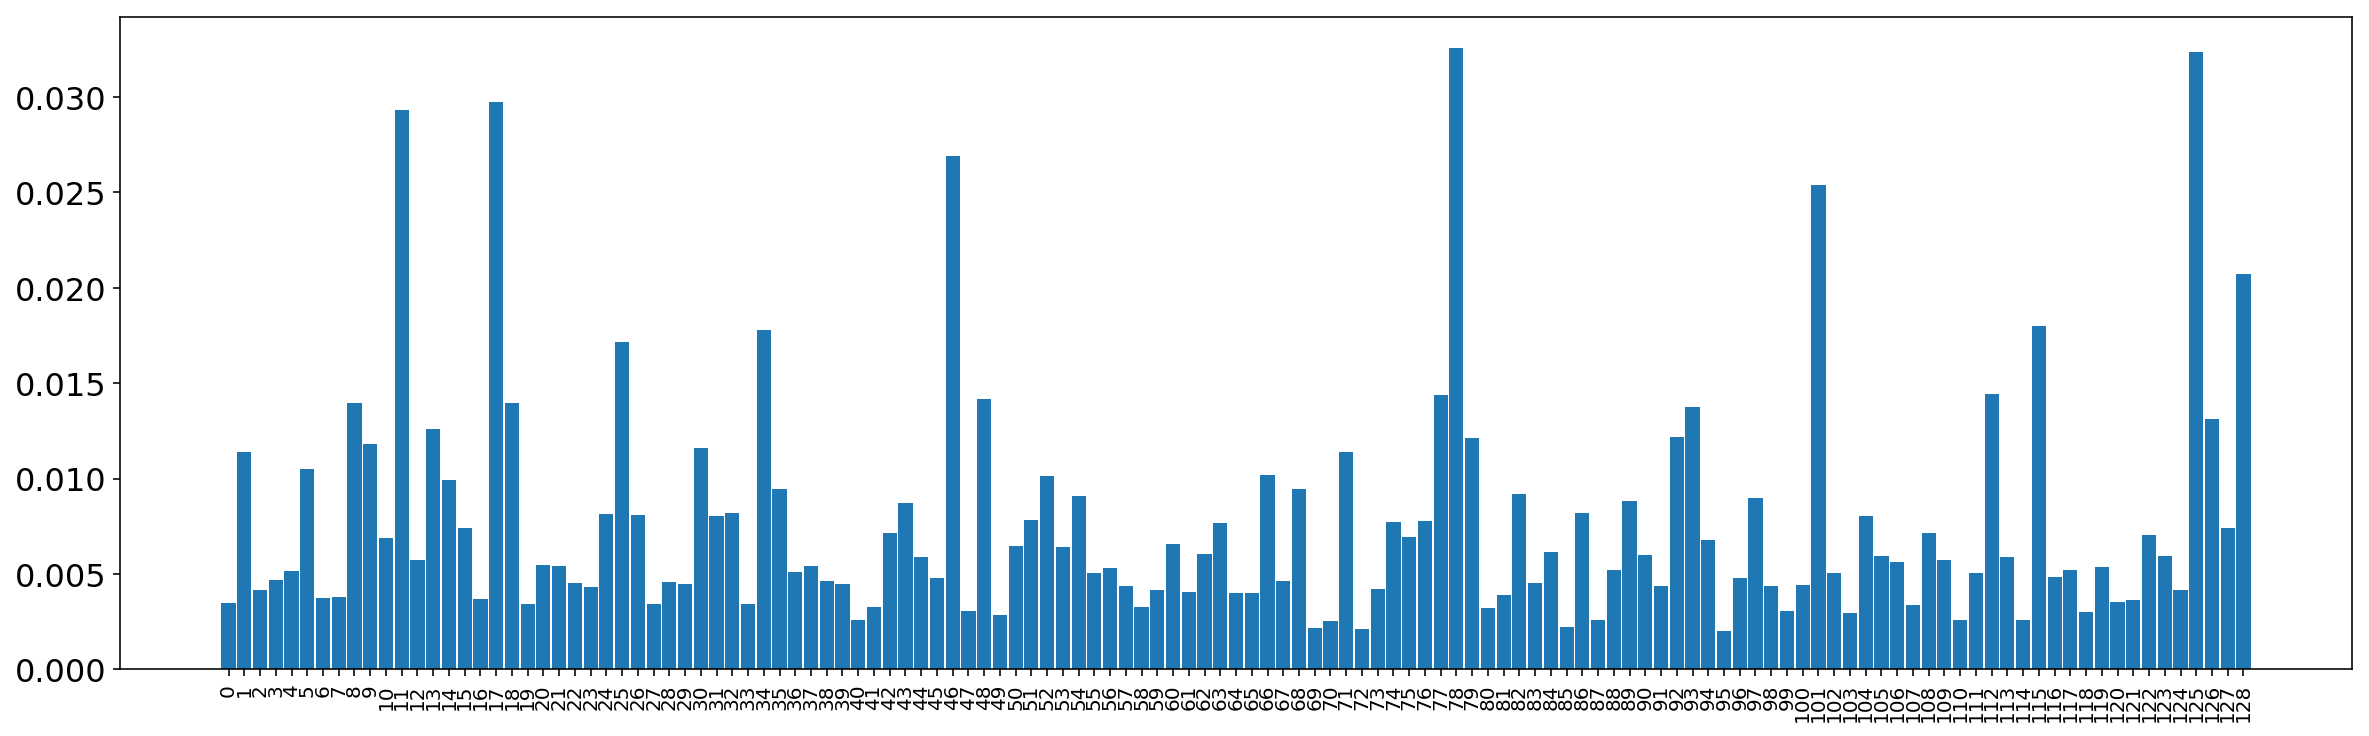

In [518]:
#forest = RandomForestClassifier(n_estimators = 37) 
clf = clf_models[3]
#forest = forest.fit(x_train, y_train)
#test_preds = clf.predict(x_test)

#clf = svm.SVC(decision_function_shape='ovo',random_state=RANDOM_STATE)
#clf = clf.fit(x_train, y_train)
#test_preds = clf.predict(x_test)

import pylab

features = clf.feature_importances_


pylab.figure(1,figsize=(20,6))
x = range(len(features))
pylab.xticks(x,rotation='vertical')

pylab.yticks(fontsize=16)
pylab.bar(x,features,align="center",width=0.9)
pylab.show()

In [277]:

#visual.plot_confusion_matrix(y_test, test_preds, 'Prediction of Ratings with a RFC Classifier')

In [220]:
from sklearn.externals import joblib
joblib.dump(clf, 'best_RFC_text_SSS.pkl', compress=9)
#model_clone = joblib.load('best_SVM_text.pkl')

['best_RFC_text_SSS.pkl']